In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import os
os.chdir("C:/Users/rober/project/B_Data_pre_processing/My_functions")
from D_metrics_multiclass import calc_multiclass_metrics
from E_MAEweighted_funct import MAE_weighted
os.chdir("C:/Users/rober/project/F_Extra_Experiments_Abstracts/")
import time

import xgboost as xgb
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import classification_report, fbeta_score, make_scorer, precision_score, accuracy_score, f1_score,  recall_score, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

## Steps:

> 1. Load pre-processed text
> 2. Split in three datasets and divide the features from the targets
> 3. Word representation using TF-IDF 
> 4. Using SMOTE to Balanced the train data
> 5. Train the two best learning algorithms - Random Forest and XGBoost


        First algorithm Random Forest:
        
>>        5.1 Train and test Random Forest and TF-IDF both untuned
>>        5.2 Tune TF-IDF
>>        5.3 Train and test Random Forest with only TF-IDF tuned
>>        5.4 Tune hyperparameters Random Forest
>>        5.5 Train and test Random Forest with TF-IDF both tuned
        
        Second algorithm XGBoost:
        
>>        5.6 Train and test XGBoost and TF-IDF both untuned
>>        5.7 Tune TF-IDF
>>        5.8 Train and test XGBoost with only TF-IDF tuned
>>        5.9 Tune hyperparameters XGBoost
>>        5.10 Train and test XGBoost with TF-IDF both tuned
        
> 6. Best model    

***

# 1. Load pre-processed text

In [2]:
with open(ospath('~/code_final_project/B_Data_pre_processing/Pickle_Files/Claims_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)

In [3]:
db.head()

,publn_nr,type,label,text,text_clean
1,4254843,Claim 1,product,An electrically powered vehicle comprising: a ...,electrically power vehicle comprise body suppo...
2,4254843,Claim 2,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
3,4254843,Claim 3,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
4,4254843,Claim 4,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...
5,4254843,Claim 5,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...


This convert name labels form string to numbers and merge into only two classes:
Process 0, Product 1 and Use claim 2

In [4]:
db['label'] = db.label.replace(to_replace=['process', 'product','use claim'], value=[0, 1, 2])
db = db[(db['label'] != 'product and process')]
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
0,740,740,740,740
1,3809,3809,3809,3809
2,307,307,307,307


# 2. Split in three datasets and divide the features from the targets


Train 50%, validation 25% and test 25%.

In [5]:
def split_train_test_val(db):
    
    random.seed(8)
    pat_nr = list(db['publn_nr'].unique())
    print('number of patents :',str(len(pat_nr )))
    
    test =  random.sample(pat_nr, 48)

    train_test = [i for i in pat_nr if i not in test]

    val = random.sample(train_test, 48)

    train = [i for i in train_test if i not in val]

    #create an empty data set
    train_db = pd.DataFrame()                             
    for num in range(len(train)):   
        train_db = train_db.append(db.loc[db['publn_nr'] == train[num]], ignore_index=True)

    #create an empty data set
    val_db = pd.DataFrame()                             
    for num in range(len(val)):   
        val_db = val_db.append(db.loc[db['publn_nr'] == val[num]], ignore_index=True)

    #create an empty data set
    test_db = pd.DataFrame()                             
    for num in range(len(test)):   
        test_db = test_db.append(db.loc[db['publn_nr'] == test[num]], ignore_index=True)

    print('-'*80,'\n')
    print('Train data:')
    print('Train data shape: {} \nNumber of patents: {}'.format(train_db.shape ,len(train_db['publn_nr'].unique())))
    print('First patent number train:',train_db['publn_nr'].iloc[0])
    print()
    print('Train frequency classes:',train_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Test data:')
    print('Test data shape: {} \nNumber of patents: {}'.format(test_db.shape, len(test_db['publn_nr'].unique())))
    print('First patent number test:',test_db['publn_nr'].iloc[0])
    print()
    print('Test frequency classes:',test_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Val data:')
    print('Val data shape: {} \nNumber of patents: {}'.format(val_db.shape, len(val_db['publn_nr'].unique())))
    print('First patent number val:',val_db['publn_nr'].iloc[0])
    print()
    print('Val frequency classes:',val_db.groupby(by='label').count().iloc[:,:1],'\n')
    
    
    return train_db, test_db, val_db

train_db, test_db, val_db = split_train_test_val(db) 


number of patents : 194
-------------------------------------------------------------------------------- 

Train data:
Train data shape: (2319, 5) 
Number of patents: 98
First patent number train: 4254843

Train frequency classes:        publn_nr
label          
0           370
1          1770
2           179
-------------------------------------------------------------------------------- 

Test data:
Test data shape: (1106, 5) 
Number of patents: 48
First patent number test: 7009401

Test frequency classes:        publn_nr
label          
0           205
1           846
2            55
-------------------------------------------------------------------------------- 

Val data:
Val data shape: (1431, 5) 
Number of patents: 48
First patent number val: 5961672

Val frequency classes:        publn_nr
label          
0           165
1          1193
2            73 



### Separate for the three datasets the features from the labels

In [6]:
X_train = train_db['text_clean']
y_train = train_db['label']

X_val = val_db['text_clean']
y_val = val_db['label']

X_test = test_db['text_clean']
y_test = test_db['label']

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

# 3. Word representation using TF-IDF
I will not select now the features dimension. I run the model with all the features

In [7]:
tfidf = TfidfVectorizer(ngram_range = (1,2), encoding='utf-8')

X_train_tf = tfidf.fit_transform(X_train).toarray()
X_test_tf = tfidf.transform(X_test).toarray()
X_val_tf = tfidf.transform(X_val).toarray()


y_train = y_train.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

# 4. Using SMOTE to Balanced the train data

In [8]:
balance = SMOTE()
X_train_bal, y_train_bal = balance.fit_resample(X_train_tf, y_train)

Initiation dataset to store all the results

In [9]:
results_score = pd.DataFrame()

# First Learning Algorithm
## 5.1 Train and test Random Forest and TF-IDF both untuned

### First, I train the random forest model without any tuning and no feature diemension selected.

Train and evaluate the model with validation data. 

In [10]:
rf = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_val_tf)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_pred)))

Accuracy on validation data: 
 0.9287211740041929
Confusion Matrix validation: 
[[ 113   51    1]
 [   7 1186    0]
 [   3   40   30]]


Store the results in dataset results scores.

In [11]:
sc = calc_multiclass_metrics(y_val, rf_pred, 'RF not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.77399,0.928721,0.696647,0.783159


Now, I evalaute tmhe model with the test data

In [12]:
rf_pred_test = rf.predict(X_test_tf)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_pred_test))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_test, rf_pred_test)))

Accuracy on the test data: 
 0.9132007233273056
Confusion Matrix validation: 
[[148  50   7]
 [  5 841   0]
 [  8  26  21]]


In [13]:
sc = calc_multiclass_metrics(y_test, rf_pred_test, 'RF not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410


## 5.2 Tuning Hyperparameters TF-IDF

Tuning on the validation set using Grid Search

In [14]:
pipe_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state = 8))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]
}

grid_search_tfidf = GridSearchCV(pipe_grid, param_grid, cv=2, n_jobs=2, verbose=3)
grid_search_tfidf.fit(X_val, y_val)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   10.5s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=RandomForestClassifier(random_state=8)))]),
             n_jobs=2,
             param_grid={'tfidf__max_features': (300, 350, 400, 450, 500),
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__sublinear_tf': [True, False]},
             verbose=3)

Now, with the new paramaters for the TFIDF vectorizer

In [15]:
print('Best set of parameters: \n', grid_search_tfidf.best_estimator_[0])

Best set of parameters: 
 TfidfVectorizer(lowercase=False, max_features=450, norm='l1', sublinear_tf=True)


In [16]:
tfidf_tune = grid_search_tfidf.best_estimator_[0]

X_train_tf_tune = tfidf.fit_transform(X_train).toarray()
X_test_tf_tune = tfidf.transform(X_test).toarray()
X_val_tf_tune = tfidf.transform(X_val).toarray()

I use SMOTE again to balance the dataset

In [17]:
balance = SMOTE()
X_train_tune_bal, y_train_tune__bal = balance.fit_resample(X_train_tf_tune, y_train)

## 5.3 Train and test Random Forest with only TF-IDF tuned

In [18]:
rf_tf_tune = RandomForestClassifier(random_state = 8, n_jobs = -1)
rf_tf_tune.fit(X_train_tune_bal, y_train_tune__bal)
rf_tf_tune_pred = rf_tf_tune.predict(X_val_tf_tune)

print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_tf_tune_pred)))

Accuracy on validation data: 
 0.9371069182389937
Confusion Matrix validation: 
[[ 116   46    3]
 [   6 1187    0]
 [   5   30   38]]


In [19]:
sc = calc_multiclass_metrics(y_val, rf_tf_tune_pred, 'RF TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721


Test the model

In [20]:
rf_tf_tune_pred_test = rf_tf_tune.predict(X_test_tf)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_tf_tune_pred_test))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_test, rf_tf_tune_pred_test)))

Accuracy on the test data: 
 0.9213381555153707
Confusion Matrix validation: 
[[158  43   4]
 [  7 839   0]
 [ 10  23  22]]


In [21]:
sc = calc_multiclass_metrics(y_test, rf_tf_tune_pred_test, 'RF TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323


## 5.4 Tune Hyperparameters Random Forest algorithm

I set here the list of parameters to be fitted. For tune the hyperparameter for the learning algorithm, I used Random search method

Hyperparameters tuned on validation data.

In [22]:
param_grid = {'min_samples_leaf': [1, 2, 4],
              'min_samples_split' : [2, 5, 10],
             'max_features' : ['auto', 'sqrt'],
              'max_depth': [20, 40, 60, 80, 100, None],
              'n_estimators' : [200, 400, 600, 800, 1000],
             'bootstrap' : [True, False]}

In [23]:
rand_for = RandomForestClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=rand_for,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

random_search.fit(X_val_tf_tune, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 54.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy', verbose=1)

#### Print the best parameters

In [24]:
print(random_search.best_params_)

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


## 5.5 Train and test Random Forest and TF-IDF both tuned

In [25]:
rf_both_tune = random_search.best_estimator_
rf_both_tune_pred = rf_both_tune.predict(X_val_tf_tune)
print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, rf_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, rf_both_tune_pred)))

Accuracy on validation data: 
 0.9993011879804332
Confusion Matrix validation: 
[[ 165    0    0]
 [   1 1192    0]
 [   0    0   73]]


In [26]:
sc = calc_multiclass_metrics(y_val, rf_both_tune_pred, 'RF TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729


In [27]:
rf_both_tune_pred_test = rf_both_tune.predict(X_test_tf_tune)
print("Accuracy on the test data: \n", metrics.accuracy_score(y_test, rf_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, rf_both_tune_pred_test)))

Accuracy on the test data: 
 0.8743218806509946
Confusion Matrix test: 
[[114  75  16]
 [  2 844   0]
 [  3  43   9]]


In [28]:
sc = calc_multiclass_metrics(y_test, rf_both_tune_pred_test, 'RF TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125


## Second Learning Algorithm
## 5.6 Train and test XGboost and TF-IDF both untuned
 

I run first the XGBoost algorithm with the TF-IDF vectorizer not tuned - no features dimension selected - and the data balanced with SMOTE.

Trains and evaluate the new Learning algorithm with validation data 

In [29]:
xb = xgb.XGBClassifier(objective = 'multi:softmax',  num_class = 3, n_jobs=-1)
xb.fit(X_train_bal, y_train_bal)

xb_pred = xb.predict(X_val_tf)
print(metrics.accuracy_score(y_val, xb_pred))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_val, xb_pred)))

0.9818308874912649
Confusion Matrix test: 
[[ 160    2    3]
 [   6 1186    1]
 [  10    4   59]]


In [30]:
sc = calc_multiclass_metrics(y_val, xb_pred, 'XGBost not tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209


In [31]:
xb_pred_test = xb.predict(X_test_tf)
print(metrics.accuracy_score(y_test, xb_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_pred_test)))

0.9529837251356239
Confusion Matrix test: 
[[179  13  13]
 [  2 843   1]
 [ 23   0  32]]


In [32]:
sc = calc_multiclass_metrics(y_test, xb_pred_test, 'XGBost not tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209
0,XGBost not tuned,Test,0.852639,0.817148,0.969644,0.833189,0.952984,0.817148,0.893396


In [33]:
#print(metrics.multilabel_confusion_matrix(y_test, pred_val))

## 5.7 Tune parameters TF-IDF vectorizer

In [34]:
pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(xgb.XGBClassifier(objective = 'multi:softmax',  num_class = 3, n_jobs=-1))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]

}

grid_search_tfidf_xgb = GridSearchCV(pipeline_grid, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search_tfidf_xgb.fit(X_val, y_val)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.9s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    gamma=None,
                                                                                    gpu_id=None,
                                                                                    importance_t

In [35]:
print("Best parameters for the TF-IDF: \n" ,grid_search_tfidf_xgb.best_estimator_[0])

Best parameters for the TF-IDF: 
 TfidfVectorizer(lowercase=False, max_features=500, sublinear_tf=True)


In [36]:
tfidf_tune_xb = grid_search_tfidf_xgb.best_estimator_[0]

X_train_tf_tune_xb = tfidf_tune_xb.fit_transform(X_train).toarray()
X_test_tf_tune_xb = tfidf_tune_xb.transform(X_test).toarray()
X_val_tf_tune_xb = tfidf_tune_xb.transform(X_val).toarray()

Using SMOTE again.

In [37]:
balance = SMOTE()
X_train_tune_bal_xb, y_train_tune_bal_xb = balance.fit_resample(X_train_tf_tune_xb, y_train)

## 5.8 Train and test XGBoost with TF-IDF tuned

In [38]:
xb_tf_tune = xgb.XGBClassifier(objective = 'multi:softmax',  num_class = 3, n_jobs=-1)
xb_tf_tune.fit(X_train_tune_bal_xb, y_train_tune_bal_xb)
xb_tf_tune_pred = xb_tf_tune.predict(X_val_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_tf_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, xb_tf_tune_pred)))

Accuracy on validation data: 
 0.9804332634521313
Confusion Matrix validation: 
[[ 153    3    9]
 [   9 1183    1]
 [   3    3   67]]


In [39]:
sc = calc_multiclass_metrics(y_val, xb_tf_tune_pred, 'XGBost TF tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209
0,XGBost not tuned,Test,0.852639,0.817148,0.969644,0.833189,0.952984,0.817148,0.893396
0,XGBost TF tuned,Validation,0.930785,0.945566,0.985982,0.937963,0.980433,0.945566,0.965774


In [40]:
xb_tf_tune_pred_test = xb_tf_tune.predict(X_test_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, xb_tf_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_tf_tune_pred_test)))

Accuracy on test data: 
 0.961121157323689
Confusion Matrix test: 
[[180  12  13]
 [  2 843   1]
 [ 15   0  40]]


In [41]:
sc = calc_multiclass_metrics(y_test, xb_tf_tune_pred_test, 'XGBost TF tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209
0,XGBost not tuned,Test,0.852639,0.817148,0.969644,0.833189,0.952984,0.817148,0.893396
0,XGBost TF tuned,Validation,0.930785,0.945566,0.985982,0.937963,0.980433,0.945566,0.965774
0,XGBost TF tuned,Test,0.880137,0.867258,0.973886,0.873550,0.961121,0.867258,0.920572


## 5.9 Tune Hyperparameters XGBoost algorithm

In [42]:
param_grid = {
    'max_depth': [2,4,6,8,10],
    'n_estimators': [60, 10,120,160,200, 240],
    'learning_rate': [0.1, 0.01, 0.05, 0.009]
}

In [43]:
xb = xgb.XGBClassifier(objective = 'multi:softmax',  num_class = 3, n_jobs=-1)



# Definition of the random search
random_search = RandomizedSearchCV(estimator=xb,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

# Fit the random search model
random_search.fit(X_val_tf_tune_xb, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_class=3, num_parallel_tree=None,
                                           objective='multi:softmax',
                               

In [44]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=240, n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


## 5.10 Train and test XGBoost and TF-IDF both untuned

In [45]:
xb_both_tune = random_search.best_estimator_
xb_both_tune.fit(X_train_tune_bal_xb, y_train_tune_bal_xb)
xb_both_tune_pred = xb_both_tune.predict(X_val_tf_tune_xb)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_val, xb_both_tune_pred)))

Accuracy on validation data: 
 0.9741439552760307
Confusion Matrix validation: 
[[ 153    2   10]
 [   8 1182    3]
 [   9    5   59]]


In [46]:
print("Accuracy on validation data: \n",metrics.accuracy_score(y_val, xb_both_tune_pred))

Accuracy on validation data: 
 0.9741439552760307


In [47]:
sc = calc_multiclass_metrics(y_val, xb_both_tune_pred, 'XGBoost TF and Algorithm tuned', 'Validation')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209
0,XGBost not tuned,Test,0.852639,0.817148,0.969644,0.833189,0.952984,0.817148,0.893396
0,XGBost TF tuned,Validation,0.930785,0.945566,0.985982,0.937963,0.980433,0.945566,0.965774
0,XGBost TF tuned,Test,0.880137,0.867258,0.973886,0.873550,0.961121,0.867258,0.920572


In [48]:
xb_both_tune_pred_test = xb_both_tune.predict(X_test_tf_tune_xb)
print("Accuracy on test data: \n",metrics.accuracy_score(y_test, xb_both_tune_pred_test))
print("Classification report: \n",metrics.classification_report(y_test, xb_both_tune_pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, xb_both_tune_pred_test)))

Accuracy on test data: 
 0.9403254972875226
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84       205
           1       0.98      0.99      0.99       846
           2       0.60      0.56      0.58        55

    accuracy                           0.94      1106
   macro avg       0.81      0.79      0.80      1106
weighted avg       0.94      0.94      0.94      1106

Confusion Matrix test: 
[[168  17  20]
 [  4 841   1]
 [ 21   3  31]]


In [49]:
sc = calc_multiclass_metrics(y_test, xb_both_tune_pred_test, 'XGBoost TF and Algorithm tuned', 'Test')
results_score = results_score.append(sc)
results_score

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,RF not tuned,Validation,0.938393,0.696647,0.869671,0.773990,0.928721,0.696647,0.783159
0,RF not tuned,Test,0.862125,0.699286,0.895535,0.756274,0.913201,0.699286,0.797410
0,RF TF tuned,Validation,0.926680,0.739516,0.889925,0.809267,0.937107,0.739516,0.814721
0,RF TF tuned,Test,0.892028,0.720819,0.907827,0.777699,0.921338,0.720819,0.814323
0,RF TF and Algorithm tuned,Validation,0.997992,0.999721,0.999737,0.998853,0.999301,0.999721,0.999729
0,RF TF and Algorithm tuned,Test,0.731774,0.572457,0.841794,0.620777,0.874322,0.572457,0.707125
0,XGBost not tuned,Validation,0.946855,0.924016,0.986402,0.933538,0.981831,0.924016,0.955209
0,XGBost not tuned,Test,0.852639,0.817148,0.969644,0.833189,0.952984,0.817148,0.893396
0,XGBost TF tuned,Validation,0.930785,0.945566,0.985982,0.937963,0.980433,0.945566,0.965774
0,XGBost TF tuned,Test,0.880137,0.867258,0.973886,0.873550,0.961121,0.867258,0.920572


## 6 Best Model

Text(0.5, 1.0, 'XGBoost TF tuned')

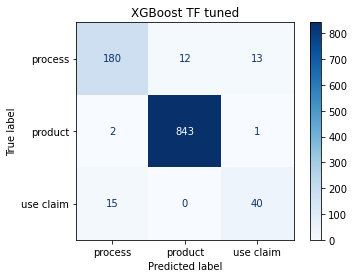

In [53]:
plot_conf = metrics.plot_confusion_matrix(xb_tf_tune, X_test_tf_tune_xb, y_test, values_format = 'n',
                                   cmap=plt.cm.Blues, display_labels = ['process' , 'product', 'use claim'] )
title = 'XGBoost TF tuned'
plot_conf.ax_.set_title(title)

In [51]:
grid_search_tfidf_xgb.best_params_

{'tfidf__max_features': 500, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}

In [52]:
MAE_weighted(xb_tf_tune_pred_test, test_db, binary_class = 'No')

'MAE-weighted is 0.005204097443644654'

In [54]:
results_score.iloc[9]

Model           XGBost TF tuned
Data                       Test
Precision              0.880137
Recall                 0.867258
Specificity            0.973886
F1-score                0.87355
Accuracy               0.961121
Bal Accuracy           0.867258
AUC                    0.920572
Name: 0, dtype: object

In [55]:
#save the model
with open(ospath('~/code_final_project/Z_Best_models_saved/Claims/Best_Multiclass_model.pickle.pickle'), 'wb') as model:
    pickle.dump(xb_tf_tune, model)
    
#save tf-df fitted vectorizer to use for the best model
with open(ospath('~/code_final_project/Z_Best_models_saved/Claims/Best_tf_idf_for_multiclass_model.pickle'), 'wb') as model:
    pickle.dump(tfidf_tune_xb, model)